### Packed Padded Sequences, Masking, Inference and BLEU Metric

In this notebook we will be adding a few improvements - `packed padded sequences` and `masking` - to the model from the previous notebook. Packed padded sequences are used to tell our `RNN` to skip over padding tokens in our encoder. `Masking` explicitly forces the model to ignore certain values, such as attention over padded elements. Both of these techniques are commonly used in `NLP`.

We will also look at how to use our model for `inference`, by giving it a sentence, seeing what it translates it as and seeing where exactly it pays attention to when translating each word.

Finally, we'll use the `BLEU` metric to measure the quality of our translations.

> This notebook is nothing but a modified version of my previous notebooks on `seq2seq` machine translation model. The only difference is that in this notebook we are going to use the `torchtext` api instead of the `torchtext.lergacy`. The following notebooks are used as refences to this notebook. There you will find a deep understanding on how `Seq2Seq` models work.

1. [04_Packed_Padded_Sequences%2C_Masking%2C_Inference_and_BLEU.ipynb](https://github.com/CrispenGari/pytorch-python/blob/main/09_NLP/03_Sequence_To_Sequence/04_Packed_Padded_Sequences%2C_Masking%2C_Inference_and_BLEU.ipynb)


### Installation of Packages
In the following code cell we are going to install the packages that we are going to use in this notebook which are `helperfns` and `torchdata`. The `helperfns` package allows us to get some machine learning helper function which we are also going to use in this notebook as well.

In [1]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [2]:
!pip install helperfns portalocker torchdata -q

  Preparing metadata (setup.py) ... done


### Imports

In the following code cell we are going to import the packages that are going to be used in this notebook.

In [3]:

from torch import nn
from torch.nn  import functional as F
from torchtext import data, datasets
from collections import Counter
from torchtext import vocab
from helperfns import tables, visualization, utils
from helperfns.torch.models import model_params
from matplotlib import pyplot as plt

import spacy
import math
import random
import torch
import torchtext
import numpy as np
import time
import gc

torchtext.__version__, torch.__version__

('0.15.2+cpu', '2.0.1+cu118')

In [4]:
torch.cuda.empty_cache()

### Seed
In the following code cell we are going to set up the `SEED` for reproducivity in this notebook.

In [5]:
SEED = 42

torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deteministic = True

### Device

In the following code cell we are going to declare a `device` variable that will allow us to make use of `GPU` if available.

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Tokenizer Models

For the tokenizer we are going to make use of the `spacy` language models to tokenize sentences for each language. So first we will need to download the `en_core_web_sm` and the `de_core_news_sm`.

In [7]:
spacy.cli.download('de_core_news_sm')

✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')


In [8]:
spacy_de = spacy.load('de_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

In the following code cell we are going to create our tokenizers functions that takes in a sentence in english and tokenize it.

> Previously we reversed the source (German) sentence, however in the paper we are implementing they don't do this, so neither will we.

In [9]:
def tokenize_de(sent:str)->list:
  return [tok.text for tok in spacy_de.tokenizer(sent)]

def tokenize_en(sent:str)->list:
  return [tok.text for tok in spacy_en.tokenizer(sent)]

Testing our tokenizer functions.

In [10]:
tokenize_de("Kannst du mir helfen?")

['Kannst', 'du', 'mir', 'helfen', '?']

In [11]:
tokenize_en("Can you help me?")

['Can', 'you', 'help', 'me', '?']

### Dataset

The dataset we'll be using is the [Multi30k](https://pytorch.org/text/stable/datasets.html#multi30k) dataset. This is a dataset with `~30,000` parallel English, German and French sentences, each with `~12` words per sentence.

In [12]:
train_iter, valid_iter, test_iter = datasets.Multi30k(
     root = '.data', split = ('train', 'valid', 'test'), 
    language_pair= ('de', 'en')
)

Checking as single train example.

In [13]:
next(iter(train_iter))

('Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.',
 'Two young, White males are outside near many bushes.')

### Getting `src` and `trg`
Our `src` field will be the `de` sentence and the `trg` field will the the `en` sentence.

In [14]:
train_src = []
train_trg = []
valid_src = []
valid_trg = []
test_src = []
test_trg = []

for (src, trg) in train_iter:
  train_src.append(src)
  train_trg.append(trg)

for (src, trg) in test_iter:
  test_src.append(src)
  test_trg.append(trg)

for (src, trg) in valid_iter:
  valid_src.append(src)
  valid_trg.append(trg)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/datapipes/iter/combining.py:297: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "


Checking if the `src` and the `trg` has the same length for all sets.

In [15]:
assert len(train_src) == len(train_trg), f"The src and trg must have the same length got {len(train_src)} and {len(train_trg)}."
assert len(valid_src) == len(valid_trg), f"The src and trg must have the same length got {len(valid_src)} and {len(valid_trg)}."
assert len(test_src) == len(test_trg), f"The src and trg must have the same length got {len(test_src)} and {len(test_trg)}."

### Counting examples

In the following code cell we are going to count examples in each language pair and visualize them using a table.

In [16]:
columns = ["set", "src", "trg"]
examples = [
    ['training', len(train_src), len(train_trg)],
    ['validation' , len(valid_src), len(valid_trg)],
    ['testing' , len(test_src), len(test_trg)],
]
tables.tabulate_data(columns, examples, "Examples")

+------------+-------+-------+
| set        |   src |   trg |
+------------+-------+-------+
| training   | 29001 | 29001 |
| validation |  1015 |  1015 |
| testing    |  1000 |  1000 |
+------------+-------+-------+


### Building Vocabulary
Next, we'll build the vocabulary for the `source` (src) and `target` (trg) languages. The vocabulary is used to associate each unique token with an index (an integer). The vocabularies of the `source` and `target` languages are distinct.

Using the `min_freq` argument, we only allow tokens that appear at least `2` times to appear in our vocabulary. Tokens that appear only once are converted into an `<unk>` (unknown) token.

> It is important to note that our vocabulary should only be built from the `training` set and not the `validation/test` set. This prevents `"information leakage"` into our model, giving us artifically inflated `validation/test` scores.

Also note that in this notebook we are not going to focus much about text cleaning. We are going to convert sentences to lower case only.

In [29]:
counter_src = Counter()
for line in train_src:
  counter_src.update(tokenize_de(line.lower()))
vocabulary_src = vocab.vocab(counter_src, min_freq=5, specials=('-unk-', '-sos-', '-eos-', '-pad-'))

counter_trg = Counter()
for line in train_trg:
  counter_trg.update(tokenize_de(line.lower()))
vocabulary_trg = vocab.vocab(counter_trg, min_freq=5, specials=('-unk-', '-sos-', '-eos-', '-pad-'))

In the following code cell we are going to get the `string-to-integer` representation of our `src` and `trg` fields.

In [30]:
stoi_src = vocabulary_src.get_stoi()
stoi_trg = vocabulary_trg.get_stoi()

SRC_VOCAB_SIZE = len(stoi_src)
TRG_VOCAB_SIZE = len(stoi_trg)

### SRC and Target Pipelines
After our text has been tokenized we need a way of converting those words into numbers because machine leaning models understand numbers not words. That's where we the `src_text_pipeline` and `trg_text_pipeline` functions into play. So these function takes in a sentence and tokenize it then converts each word to a number. Note that the word that does not exists in the vocabulay for either `src` or `trg` will be converted to an `unkown` (`-unk-`) token.

In [31]:
def src_text_pipeline(x: str)->list:
  values = list()
  tokens = tokenize_de(x.lower())
  for token in tokens:
    try:
      v = stoi_src[token]
    except KeyError as e:
      v = stoi_trg['-unk-']
    values.append(v)
  return values

def trg_text_pipeline(x: str)->list:
  values = list()
  tokens = tokenize_de(x.lower())
  for token in tokens:
    try:
      v = stoi_trg[token]
    except KeyError as e:
      v = stoi_trg['-unk-']
    values.append(v)
  return values

#### Translation Dataset

In the following code cell we are going to create a `TranslationDataset` class which will inherid from the `torch.utils.data.Dataset` class. This class will take in the `src` and `trg` values and pair them together.

In [32]:
class TranslationDataset(torch.utils.data.Dataset):
  def __init__(self, src, trg):
    super(TranslationDataset, self).__init__()
    self.src = src
    self.trg = trg
      
  def __getitem__(self, index):
    return self.src[index], self.trg[index]
  
  def __len__(self):
    return len(self.src)

### collate_fn of the `DataLoader`
Our collate function will be named `tokenize_batch` which takes in the batch of `src` and `trg` pairs then `tokenize`, `numericalize` and then `pad` the to a given `max_len`.

In [33]:
def tokenize_batch(batch, max_len=100, padding="pre"):
  assert padding=="pre" or padding=="post", "the padding can be either pre or post"
  src, trg = [], []
  for src_, trg_ in batch:
    _src = torch.zeros(max_len, dtype=torch.int32)
    _trg = torch.zeros(max_len, dtype=torch.int32)
    _src_processed_text = torch.tensor(src_text_pipeline(src_.lower()), dtype=torch.int32)
    _trg_processed_text = torch.tensor(trg_text_pipeline(trg_.lower()), dtype=torch.int32)
    _src_pos = min(max_len, len(_src_processed_text))
    _trg_pos = min(max_len, len(_trg_processed_text))
    if padding == "pre":
      _src[:_src_pos] = _src_processed_text[:_src_pos]
      _trg[:_trg_pos] = _trg_processed_text[:_trg_pos]
    else:
      _src[-_src_pos:] = _src_processed_text[-_src_pos:]
      _trg[-_trg_pos:] = _trg_processed_text[-_trg_pos:]
    trg.append(_trg.unsqueeze(dim=0))
    src.append(_src.unsqueeze(dim=0))
  #  the target values must be a LongTensor
  return torch.cat(src, dim=0), torch.cat(trg, dim=0).type(torch.LongTensor)

### Creating datasets
In the following code cell we are going to create datasets for all our `3` sets.

In [34]:
train_dataset = TranslationDataset(train_src, train_trg)
test_dataset = TranslationDataset(test_src, test_trg)
valid_dataset = TranslationDataset(valid_src, valid_trg)

Checking a single example in the `train` set.

In [35]:
train_dataset[0]

('Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.',
 'Two young, White males are outside near many bushes.')

In [36]:
train_dataset[:5]

(['Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.',
  'Mehrere Männer mit Schutzhelmen bedienen ein Antriebsradsystem.',
  'Ein kleines Mädchen klettert in ein Spielhaus aus Holz.',
  'Ein Mann in einem blauen Hemd steht auf einer Leiter und putzt ein Fenster.',
  'Zwei Männer stehen am Herd und bereiten Essen zu.'],
 ['Two young, White males are outside near many bushes.',
  'Several men in hard hats are operating a giant pulley system.',
  'A little girl climbing into a wooden playhouse.',
  'A man in a blue shirt is standing on a ladder cleaning a window.',
  'Two men are at the stove preparing food.'])

In [37]:
test_dataset[:5]

(['Ein Mann mit einem orangefarbenen Hut, der etwas anstarrt.',
  'Ein Boston Terrier läuft über saftig-grünes Gras vor einem weißen Zaun.',
  'Ein Mädchen in einem Karateanzug bricht einen Stock mit einem Tritt.',
  'Fünf Leute in Winterjacken und mit Helmen stehen im Schnee mit Schneemobilen im Hintergrund.',
  'Leute Reparieren das Dach eines Hauses.'],
 ['A man in an orange hat starring at something.',
  'A Boston Terrier is running on lush green grass in front of a white fence.',
  'A girl in karate uniform breaking a stick with a front kick.',
  'Five people wearing winter jackets and helmets stand in the snow, with snowmobiles in the background.',
  'People are fixing the roof of a house.'])

In [38]:
valid_dataset[:5]

(['Eine Gruppe von Männern lädt Baumwolle auf einen Lastwagen',
  'Ein Mann schläft in einem grünen Raum auf einem Sofa.',
  'Ein Junge mit Kopfhörern sitzt auf den Schultern einer Frau.',
  'Zwei Männer bauen eine blaue Eisfischerhütte auf einem zugefrorenen See auf',
  'Ein Mann mit beginnender Glatze, der eine rote Rettungsweste trägt, sitzt in einem kleinen Boot.'],
 ['A group of men are loading cotton onto a truck',
  'A man sleeping in a green room on a couch.',
  "A boy wearing headphones sits on a woman's shoulders.",
  'Two men setting up a blue ice fishing hut on an iced over lake',
  'A balding man wearing a red life jacket is sitting in a small boat.'])

### DataLoaders

In the following code cell we are going to create  dataloaders for our three sets of data. We are going to pass the `tokenize_batch` as our `collate_fn`. We are going to shuffle example in the `train` set only.

In [39]:
BATCH_SIZE = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=tokenize_batch)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=tokenize_batch)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=tokenize_batch)

#### Checking examples.

In [43]:
src, trg = next(iter(train_loader))

In [47]:
itos_src = {v:k for k, v in stoi_src.items()}
itos_trg = {v:k for k, v in stoi_trg.items()}

In [48]:
def tokens_to_strings(tokens, itos):
  v = list()
  for token in tokens:
    try:
      v.append(itos[token.item()])
    except KeyError:
      v.append('-unk-')
  return [i for i in v if i != "-unk-"]

In [49]:
print(tokens_to_strings(src[0], itos_src))
print(tokens_to_strings(trg[0], itos_trg))

['ein', 'mann', 'steht', 'in', 'der', 'nähe', 'eines', 'und', 'hat', 'sein', 'graues', 'shirt', 'teilweise', 'über', 'seinen', 'kopf', 'gezogen', '.']
['a', 'man', 'stands', 'near', 'a', 'pool', 'with', 'his', 'gray', 'shirt', 'partially', 'pulled', 'over', 'his', 'head', '.']


In [50]:
src, trg = next(iter(valid_loader))

In [51]:
print(tokens_to_strings(src[0], itos_src))
print(tokens_to_strings(trg[0], itos_trg))

['eine', 'gruppe', 'von', 'männern', 'lädt', 'auf', 'einen', 'lastwagen']
['a', 'group', 'of', 'men', 'are', 'loading', 'cotton', 'onto', 'a', 'truck']


In [52]:
src, trg = next(iter(test_loader))

In [53]:
print(tokens_to_strings(src[0], itos_src))
print(tokens_to_strings(trg[0], itos_trg))

['ein', 'mann', 'mit', 'einem', 'orangefarbenen', 'hut', ',', 'der', 'etwas', '.']
['a', 'man', 'in', 'an', 'orange', 'hat', 'starring', 'at', 'something', '.']


### Sequence To Sequence Model

We are going to build our model in `3` parts. The `econder`, `decoder` and `seq2seq`.

### Encoder

The changes here all within the forward method. It now accepts the `lengths` of the source sentences as well as the sentences themselves.

> **Note**: We have only used need lengths for the `src` sentences in the encoder. 

Note that the tensor containing the lengths of the sequences must be a `CPU` tensor as of the latest version of PyTorch, which we explicitly do so with `to('cpu')`. 

In [54]:
class Encoder(nn.Module):
  def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
    super(Encoder, self).__init__()

    self.embedding = nn.Embedding(input_dim, embedding_dim=emb_dim)
    self.gru = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)
    self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
    self.dropout = nn.Dropout(dropout)

  def forward(self, src, src_len):
    """ 
    src = [src len, batch size]
    src_len = [batch size]
    """
    embedded = self.dropout(self.embedding(src)) # embedded = [src len, batch size, emb dim]
    # need to explicitly put lengths on cpu!
    packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, src_len.to('cpu'))
    packed_outputs, hidden = self.gru(packed_embedded)
    """
    packed_outputs is a packed sequence containing all hidden states
    hidden is now from the final non-padded element in the batch
    """
    outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs) 
    """
    outputs is now a non-packed sequence, all hidden states obtained
    when the input is a pad token are all zeros
  
    outputs = [src len, batch size, hid dim * num directions]
    hidden = [n layers * num directions, batch size, hid dim]

    hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
    outputs are always from the last layer

    hidden [-2, :, : ] is the last of the forwards RNN 
    hidden [-1, :, : ] is the last of the backwards RNN

    initial decoder hidden is final hidden state of the forwards and backwards 
    encoder RNNs fed through a linear layer
    """
    hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))

    """
    outputs = [src len, batch size, enc hid dim * 2]
    hidden = [batch size, dec hid dim]
    """
    return outputs, hidden

### Attention Layer

The attention module is where we calculate the attention values over the source sentence.

Previously, we allowed this module to "pay attention" to padding tokens within the source sentence. However, using masking, we can force the attention to only be over non-padding elements.

The forward method now takes a mask input. This is a `[batch size, source sentence length]` tensor that is 1 when the source sentence token is not a padding token, and 0 when it is a padding token. For example, if the source sentence is: `["hello", "how", "are", "you", "?", <pad>, <pad>]`, then the mask would be `[1, 1, 1, 1, 1, 0, 0]`.

We apply the `mask` after the attention has been calculated, but before it has been normalized by the softmax function. It is applied using `masked_fill`. This fills the tensor at each element where the first argument `(mask == 0)` is true, with the value given by the second argument `(-1e10)`. In other words, it will take the un-normalized attention values, and change the attention values over padded elements to be `-1e10`. As these numbers will be miniscule compared to the other values they will become zero when passed through the softmax layer, ensuring no attention is payed to padding tokens in the source sentence.

In [55]:
class Attention(nn.Module):
  def __init__(self, enc_hid_dim, dec_hid_dim):
    super(Attention, self).__init__()
    self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
    self.v = nn.Linear(dec_hid_dim, 1, bias = False)

  def forward(self, hidden, encoder_outputs, mask):
    """
    hidden = [batch size, dec hid dim]
    encoder_outputs = [src len, batch size, enc hid dim * 2]
    """
    batch_size = encoder_outputs.shape[1]
    src_len = encoder_outputs.shape[0]
    # repeat decoder hidden state src_len times
    hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
    encoder_outputs = encoder_outputs.permute(1, 0, 2)

    """
    hidden = [batch size, src len, dec hid dim]
    encoder_outputs = [batch size, src len, enc hid dim * 2]
    """
    energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) # energy = [batch size, src len, dec hid dim]
    attention = self.v(energy).squeeze(2) # attention= [batch size, src len]
    attention = attention.masked_fill(mask == 0, -1e10)
    return F.softmax(attention, dim=1)

### Decoder

The decoder only needs a few small changes. It needs to accept a mask over the source sentence and pass this to the attention module. As we want to view the values of attention during inference, we also return the attention tensor.

In [56]:
class Decoder(nn.Module):
  def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
    super(Decoder, self).__init__()
    self.output_dim = output_dim
    self.attention = attention

    self.embedding = nn.Embedding(output_dim, emb_dim)
    self.gru = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
    self.fc = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
    self.dropout = nn.Dropout(dropout)
        
  def forward(self, input, hidden, encoder_outputs, mask):
    """
    input = [batch size]
    hidden = [batch size, dec hid dim]
    encoder_outputs = [src len, batch size, enc hid dim * 2]
    mask = [batch size, src len]
    """
    input = input.unsqueeze(0) # input = [1, batch size]
    embedded = self.dropout(self.embedding(input)) # embedded = [1, batch size, emb dim]
    a = self.attention(hidden, encoder_outputs, mask)# a = [batch size, src len]
    a = a.unsqueeze(1) # a = [batch size, 1, src len]
    encoder_outputs = encoder_outputs.permute(1, 0, 2) # encoder_outputs = [batch size, src len, enc hid dim * 2]
    weighted = torch.bmm(a, encoder_outputs) # weighted = [batch size, 1, enc hid dim * 2]
    weighted = weighted.permute(1, 0, 2) # weighted = [1, batch size, enc hid dim * 2]
    rnn_input = torch.cat((embedded, weighted), dim = 2) # rnn_input = [1, batch size, (enc hid dim * 2) + emb dim]
    output, hidden = self.gru(rnn_input, hidden.unsqueeze(0))
    
    """
    output = [seq len, batch size, dec hid dim * n directions]
    hidden = [n layers * n directions, batch size, dec hid dim]
    
    seq len, n layers and n directions will always be 1 in this decoder, therefore:
    output = [1, batch size, dec hid dim]
    hidden = [1, batch size, dec hid dim]
    this also means that output == hidden
    """
    assert (output == hidden).all()
    embedded = embedded.squeeze(0)
    output = output.squeeze(0)
    weighted = weighted.squeeze(0)

    prediction = self.fc(torch.cat((output, weighted, embedded), dim = 1)) # prediction = [batch size, output dim]
    return prediction, hidden.squeeze(0), a.squeeze(1)

###Seq2Seq (Sequence to Sequence)

The overarching `seq2seq` model also needs a few changes for packed padded sequences, masking and inference.

We need to tell it what the indexes are for the pad token and also pass the source sentence lengths as input to the forward method.

We use the pad token index to create the masks, by creating a mask tensor that is `1` wherever the source sentence is not equal to the pad token. This is all done within the `create_mask` function.

The sequence lengths as needed to pass to the encoder to use packed padded sequences.

The attention at each `time-step` is stored in the attentions

In [57]:

class Seq2Seq(nn.Module):
  def __init__(self, encoder, decoder, src_pad_idx, device):
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder
    self.device = device
    self.src_pad_idx = src_pad_idx
  
  def create_mask(self, src):
    mask = (src != self.src_pad_idx).permute(1, 0)
    return mask
  def forward(self, src, src_len, trg, teacher_forcing_ratio = 0.5):
    """
    src = [src len, batch size]
    src_len = [batch size]
    trg = [trg len, batch size]
    teacher_forcing_ratio is probability to use teacher forcing
    e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
    """
    trg_len, batch_size = trg.shape
    trg_vocab_size = self.decoder.output_dim
        
    # tensor to store decoder outputs
    outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
    """
    encoder_outputs is all hidden states of the input sequence, back and forwards
    hidden is the final forward and backward hidden states, passed through a linear layer
    """
    encoder_outputs, hidden = self.encoder(src, src_len)     
    # first input to the decoder is the <sos> tokens
    input = trg[0,:]
    mask = self.create_mask(src) # mask = [batch size, src len]
    for t in range(1, trg_len):
      # insert input token embedding, previous hidden state and all encoder hidden states and mask
      # receive output tensor (predictions) and new hidden state
      output, hidden, _ = self.decoder(input, hidden, encoder_outputs, mask)
      
      # place predictions in a tensor holding predictions for each token
      outputs[t] = output
      
      # decide if we are going to use teacher forcing or not
      teacher_force = random.random() < teacher_forcing_ratio
      
      # get the highest predicted token from our predictions
      top1 = output.argmax(1) 
      
      # if teacher forcing, use actual next token as next input
      # if not, use predicted token
      input = trg[t] if teacher_force else top1
    return outputs

### Training the `Seq2Seq`


In [58]:
INPUT_DIM = SRC_VOCAB_SIZE
OUTPUT_DIM = TRG_VOCAB_SIZE
ENC_EMB_DIM = DEC_EMB_DIM = 256
ENC_HID_DIM = DEC_HID_DIM = 512
ENC_DROPOUT = DEC_DROPOUT = 0.5
SRC_PAD_IDX = stoi_src["-pad-"]

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, SRC_PAD_IDX, device).to(device)
model


Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(3554, 256)
    (gru): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=1536, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(3275, 256)
    (gru): GRU(1280, 512)
    (fc): Linear(in_features=1792, out_features=3275, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

### Counting model parameters.
We are going to use the `model_params` function from `helperfns` to count model parameters.

In [59]:
model_params(model)

TOTAL MODEL PARAMETERS: 	14,053,579
TOTAL TRAINABLE PARAMETERS: 	14,053,579


### Initializing the weights
here, we will initialize all biases to zero and all weights from $N(0, 0.01)$.

In [60]:
def init_weights(m):
  for name, param in m.named_parameters():
    if 'weight' in name:
        nn.init.normal_(param.data, mean=0, std=0.01)
    else:
        nn.init.constant_(param.data, 0)   
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(3554, 256)
    (gru): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=1536, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(3275, 256)
    (gru): GRU(1280, 512)
    (fc): Linear(in_features=1792, out_features=3275, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

### Optimizer
For the optimizer we are going to use the `Adam` optimizer with default parameters.

In [61]:
optimizer = torch.optim.Adam(model.parameters())

### Criterion
Next, we define our loss function. The `CrossEntropyLoss` function calculates both the log softmax as well as the negative log-likelihood of our predictions.

Our loss function calculates the average loss per token, however by passing the index of the `<pad>` token as the `ignore_index` argument we ignore the loss whenever the target token is a padding token.

In [62]:
TRG_PAD_IDX = stoi_trg["-pad-"]
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

### Train Loop

Lets's first create a function that collects all gabages and clears the gabage together with empting cuda cache.


In [63]:
def clear_gpu_memory():
  torch.cuda.empty_cache()
  variables = gc.collect()
  del variables

In [64]:
def train(model, iterator, optimizer, criterion, clip):
  model.train()
  epoch_loss = 0
  for i, (src, trg) in enumerate(iterator):
    src = src.to(device)
    src_length = torch.tensor([len(s) for s in src], dtype=torch.int32)
    trg = trg.to(device)
    trg = trg.permute(1, 0)
    src = src.permute(1, 0)
    optimizer.zero_grad()
    output = model(src, src_length, trg)
    # trg = [trg len, batch size]
    # output = [trg len, batch size, output dim]
    output_dim = output.shape[-1]
    output = output[1:].view(-1, output_dim)
    trg = trg[1:].contiguous().view(-1)
    # trg = [(trg len - 1) * batch size]
    # output = [(trg len - 1) * batch size, output dim]
    loss = criterion(output, trg)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
    optimizer.step()
    epoch_loss += loss.item()
    clear_gpu_memory()
  return epoch_loss / len(iterator)

### Evaluation Funtion


In [65]:
def evaluate(model, iterator, criterion):
  model.eval()
  epoch_loss = 0
  with torch.no_grad():
    for i, (src, trg) in enumerate(iterator):
      src = src.to(device)
      src_length = torch.tensor([len(s) for s in src], dtype=torch.int32)
      trg = trg.to(device)
      trg = trg.permute(1, 0)
      src = src.permute(1, 0)
      output = model(src, src_length, trg, 0) # turn off teacher forcing
      # trg = [trg len, batch size]
      # output = [trg len, batch size, output dim]
      output_dim = output.shape[-1]
      output = output[1:].view(-1, output_dim)
      trg = trg[1:].contiguous().view(-1)
      # trg = [(trg len - 1) * batch size]
      # output = [(trg len - 1) * batch size, output dim]
      loss = criterion(output, trg)
      epoch_loss += loss.item()
      clear_gpu_memory()
  return epoch_loss / len(iterator)

### Running the training loop.
During training we are going to visualize our training metrics in tabular form. We are going to save the best model if and only if the previous validation loss is less greater than the current epoch validation loss.

In [66]:
N_EPOCHS = 10
CLIP = 1
best_valid_loss = float('inf')
MODEL_NAME = 'best-model.pt'
for epoch in range(N_EPOCHS):
    start = time.time()
    train_loss = train(model, train_loader, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_loader, criterion)
    title = f"EPOCH: {epoch+1:02}/{N_EPOCHS:02} {'saving best model...' if valid_loss < best_valid_loss else 'not saving...'}"
    end = time.time()
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), MODEL_NAME)
    data = [
       ["Training", f'{train_loss:.3f}', f'{math.exp(train_loss):7.3f}', f"{utils.hms_string(end - start)}" ],
       ["Validation", f'{valid_loss:.3f}', f'{math.exp(valid_loss):7.3f}', "" ],       
   ]
    columns = ["CATEGORY", "LOSS", "PPL", "ETA"]
    print(title)
    tables.tabulate_data(columns, data, title)

EPOCH: 01/10 saving best model...
+------------+-------+---------+------------+
| CATEGORY   |  LOSS |     PPL |        ETA |
+------------+-------+---------+------------+
| Training   | 0.722 |   2.058 | 0:12:53.87 |
| Validation | 0.638 |   1.892 |            |
+------------+-------+---------+------------+
EPOCH: 02/10 saving best model...
+------------+-------+---------+------------+
| CATEGORY   |  LOSS |     PPL |        ETA |
+------------+-------+---------+------------+
| Training   | 0.525 |   1.690 | 0:12:51.62 |
| Validation | 0.566 |   1.761 |            |
+------------+-------+---------+------------+
EPOCH: 03/10 saving best model...
+------------+-------+---------+------------+
| CATEGORY   |  LOSS |     PPL |        ETA |
+------------+-------+---------+------------+
| Training   | 0.432 |   1.540 | 0:12:52.92 |
| Validation | 0.503 |   1.654 |            |
+------------+-------+---------+------------+
EPOCH: 04/10 saving best model...
+------------+-------+---------+----

### Evaluating the Best Model

In the following code cell we are going to evaluate the best model.

In [67]:
column_names = ["Set", "Loss", "PPL", "ETA (time)"]
model.load_state_dict(torch.load(MODEL_NAME))
test_loss= evaluate(model, test_loader, criterion)
title = "Model Evaluation Summary"
data_rows = [["Test", f'{test_loss:.3f}', f'{math.exp(test_loss):7.3f}', ""]]

tables.tabulate_data(column_names, data_rows, title)

+------+-------+---------+------------+
| Set  |  Loss |     PPL | ETA (time) |
+------+-------+---------+------------+
| Test | 0.443 |   1.558 |            |
+------+-------+---------+------------+



### Model Inference

Now we can use our trained model to generate translations.

They have been cherry picked in order to show off what attention should look like on a sufficiently sized model.

Our `translate_sentence` function will do the following:

* ensure our model is in evaluation mode, which it should always be for inference
* tokenize the source sentence if it has not been tokenized (is a string)
numericalize the source sentence
* convert it to a tensor and add a batch dimension
* get the length of the source sentence and convert to a tensor
* feed the source sentence into the encoder
* create the mask for the source sentence
* create a list to hold the output sentence, initialized with an `<sos>` token
* create a tensor to hold the attention values
* while we have not hit a maximum length
  * get the input tensor, which should be either `<sos>` or the last predicted token
  * feed the input, all encoder outputs, hidden state and mask into the decoder
store attention values
  * get the predicted next token
  * add prediction to current output sentence prediction
  * break if the prediction was an `<eos>` token
* convert the output sentence from indexes to tokens
* return the output sentence (with the `<sos>` token removed) and the attention values over the sequence.

In [68]:
itos_trg = {v:k for k, v in stoi_trg.items()}

In [73]:

def translate_sentence(sent, stoi_src, stoi_trg, model, device, max_len=50):
  model.eval()
  if isinstance(sent, str):
    tokens = [token for token in tokenize_de(sent.lower())]
  else:
    tokens = [token.lower() for token in sent]
  tokens = ["-sos-"] + tokens + ["-eos-"]
  src_indexes = [stoi_src[token] if token in stoi_src else stoi_src["-unk-"]  for token in tokens]
  src_tensor = torch.LongTensor(src_indexes).unsqueeze(1).to(device)
  src_len = torch.LongTensor([len(src_indexes)])

  with torch.no_grad():
    encoder_outputs, hidden = model.encoder(src_tensor, src_len)

  mask = model.create_mask(src_tensor)
  trg_indexes = [stoi_trg['-sos-']]
  attentions = torch.zeros(max_len, 1, len(src_indexes)).to(device)

  for i in range(max_len):
    trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)
    with torch.no_grad():
      output, hidden, attention = model.decoder(trg_tensor, hidden, encoder_outputs, mask)

    attentions[i] = attention
    pred_token = output.argmax(1).item()
    trg_indexes.append(pred_token)

    if pred_token == stoi_trg['-eos-']:
       break
  trg_tokens = [itos_trg[i] for i in trg_indexes if itos_trg[i] != "-unk-"]

  return trg_tokens, attentions[:len(trg_tokens)-1]

Next, we'll make a function that displays the model's attention over the source sentence for each target token generated.

In [74]:
import matplotlib.ticker as ticker

def display_attention(sentence, translation, attention):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(111)
  attention = attention.squeeze(1).cpu().detach().numpy()
  cax = ax.matshow(attention, cmap='bone')
  ax.tick_params(labelsize=15)
  x_ticks = [''] + ['-sos-'] + [t.lower() for t in tokenize_de(sentence)] + ['-eos-']
  y_ticks = [''] + translation
  ax.set_xticklabels(x_ticks, rotation=45)
  ax.set_yticklabels(y_ticks)
  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
  plt.show()
  plt.close()

Now, we'll grab some translations from our dataset and see how well our model did. Note, we're going to cherry pick examples here so it gives us something interesting to look at, but feel free to change the `example_idx` value to look at different examples.

First, we'll get a source and target from our dataset.

In [75]:
example_idx = 0

src = train_src[example_idx]
trg = train_trg[example_idx]
print(f'src = {src}')
print(f'trg = {trg}')

src = Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.
trg = Two young, White males are outside near many bushes.


Then we'll use our `translate_sentence` function to get our predicted translation and attention. We show this graphically by having the source sentence on the x-axis and the predicted translation on the y-axis. The lighter the square at the intersection between two words, the more attention the model gave to that source word when translating that target word.

Below is an example the model attempted to translate.

In [76]:
tokens, attention = translate_sentence(src,  stoi_src, stoi_trg, model, device)
print(tokens)

['-sos-', 'young', 'white', 'males', 'are', 'outside', 'near', 'near', 'bushes', 'near', 'bushes', '.']


<ipython-input-74-78c5c7df9fd7>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, rotation=45)
<ipython-input-74-78c5c7df9fd7>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticks)


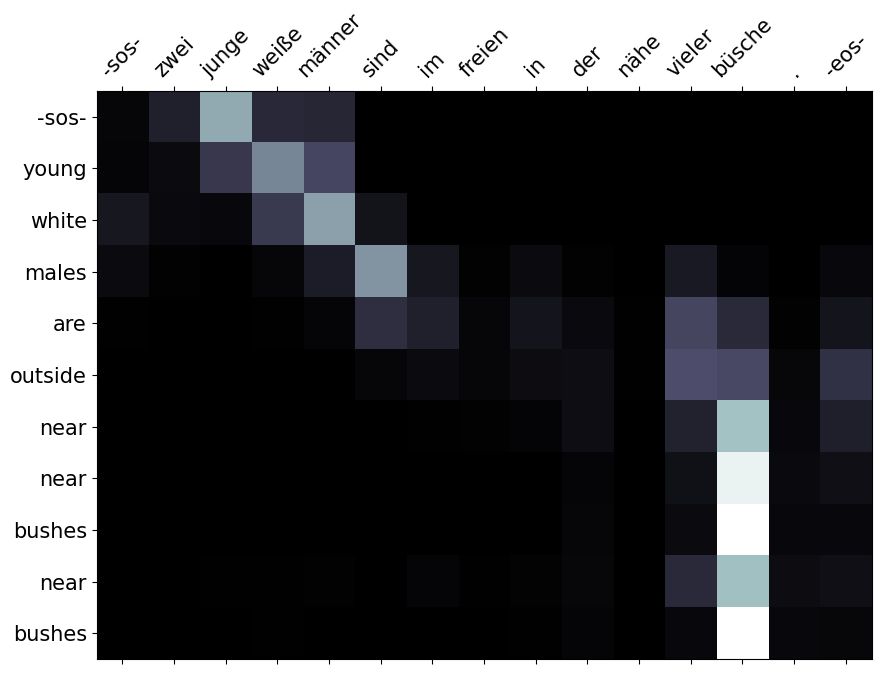

In [77]:
display_attention(src, tokens, attention)

### Validation example.

In [78]:
example_idx = 0

src = valid_src[example_idx]
trg = valid_trg[example_idx]
print(f'src = {src}')
print(f'trg = {trg}')

src = Eine Gruppe von Männern lädt Baumwolle auf einen Lastwagen
trg = A group of men are loading cotton onto a truck


In [79]:
tokens, attention = translate_sentence(src, stoi_src, stoi_trg, model, device)
print(tokens)

['-sos-', 'a', 'on', 'a', 'truck', 'that', 'has', 'a']


<ipython-input-74-78c5c7df9fd7>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, rotation=45)
<ipython-input-74-78c5c7df9fd7>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticks)


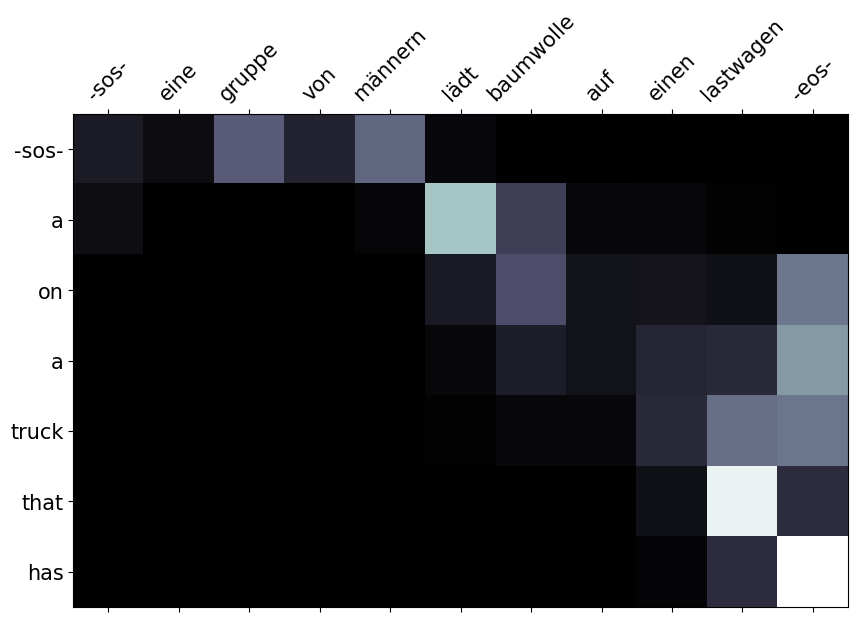

In [80]:
display_attention(src, tokens, attention)

### Test Example

In [81]:
example_idx = 0

src = test_src[example_idx]
trg = test_trg[example_idx]
print(f'src = {src}')
print(f'trg = {trg}')

src = Ein Mann mit einem orangefarbenen Hut, der etwas anstarrt.
trg = A man in an orange hat starring at something.


In [82]:
tokens, attention = translate_sentence(src,  stoi_src, stoi_trg, model, device)
print(tokens)

['-sos-', 'man', 'wearing', 'an', 'hat', 'hat', 'something', 'something']


<ipython-input-74-78c5c7df9fd7>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, rotation=45)
<ipython-input-74-78c5c7df9fd7>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticks)


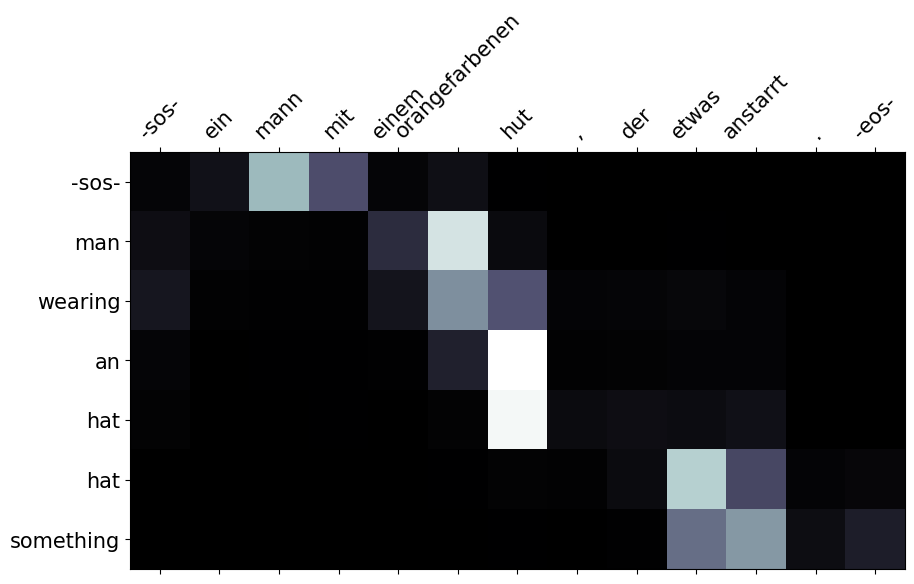

In [83]:
display_attention(src, tokens, attention)

### The `BLUE` Matric

Previously we have only cared about the `loss/perplexity` of the model. However there metrics that are specifically designed for measuring the quality of a translation - the most popular is `BLEU`. Without going into too much detail, BLEU looks at the overlap in the predicted and actual target sequences in terms of their n-grams. It will give us a number between `0` and `1` for each sequence, where `1` means there is perfect overlap, i.e. a perfect translation, although is usually shown between `0` and `100`. BLEU was designed for multiple candidate translations per source sequence, however in this dataset we only have one candidate per source.

We define a `calculate_bleu` function which calculates the `BLEU` score over a provided TorchText dataset. This function creates a corpus of the actual and predicted translation for each source sentence and then calculates the BLEU score.


In [84]:
from torchtext.data.metrics import bleu_score
def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):
  trgs = []
  pred_trgs = []
  for (src, trg) in data:
    pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)
    # cut off <eos> token
    pred_trg = pred_trg[:-1]
    pred_trgs.append(pred_trg)
    trgs.append([trg])
  return bleu_score(pred_trgs, trgs)

This number isn't really interpretable, we can't really say much about it. The most useful part of a BLEU score is that it can be used to compare different models on the same dataset, where the one with the higher **BLEU score is "better"**.

In [85]:
bleu_score = calculate_bleu(zip(test_src, test_trg), stoi_src, stoi_trg, model, device)
print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 0.00


### What's Next?
In the next notebook we will be moving away from using recurrent neural networks and start looking at other ways to construct sequence-to-sequence models. Specifically, in the next notebook we will be using convolutional neural networks.